In this notebook, I will fit a Linear Mixed Model.
Our goal is to predict the noise level.

Install the necessary packages: numpy, pandas, matplotlib.plt, seaborn

In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# change the wroking directory for easier data access
os.chdir('C:/Users/konst/OneDrive - KU Leuven/Courses/Modern Analytics/2022-2023/Project/data')

In [3]:
raw_data = pd.read_csv("https://s3.eu-central-1.amazonaws.com/mda.project.monaco/project_data.csv")
raw_data.columns

Index(['description', 'result_timestamp', 'laeq', 'hour', 'month',
       'day_of_week', 'night_of_week', 'lat', 'lon', 'lc_dwptemp', 'lc_rainin',
       'lc_dailyrain', 'lc_windspeed', 'lc_temp_qcl0', 'lc_temp_qcl1',
       'lc_temp_qcl2', 'lc_temp_qcl3', 'count'],
      dtype='object')

In [4]:
only_location_code = raw_data['description'].str.slice(stop=5)
mydata = raw_data.copy()
#mydata = mydata[mydata['description'].str.contains('MP 06','MP 07')]
mydata=mydata.drop(columns=['description','result_timestamp'])
mydata['desc']=only_location_code
mydata.head(10)

,laeq,hour,month,day_of_week,night_of_week,lat,lon,lc_dwptemp,lc_rainin,lc_dailyrain,lc_windspeed,lc_temp_qcl0,lc_temp_qcl1,lc_temp_qcl2,lc_temp_qcl3,count,desc
0,61.989333,0,4,Friday,Thursday,50.87725,4.700713,1.35,0.0,0.0,0.01,3.34,3.34,3.283,3.238540,13,MP 01
1,62.095500,0,4,Friday,Thursday,50.87725,4.700713,1.42,0.0,0.0,0.00,3.38,3.38,3.323,3.294944,13,MP 01
2,63.908667,0,4,Friday,Thursday,50.87725,4.700713,1.35,0.0,0.0,0.09,3.33,3.33,3.273,3.385025,13,MP 01
3,65.064833,0,4,Friday,Thursday,50.87725,4.700713,1.28,0.0,0.0,0.04,3.28,3.28,3.223,3.279090,13,MP 01
4,67.710833,0,4,Friday,Thursday,50.87725,4.700713,1.24,0.0,0.0,0.03,3.23,3.23,3.173,3.201228,13,MP 01
5,50.266000,0,4,Friday,Thursday,50.87725,4.700713,4.02,0.0,0.0,0.40,7.17,7.17,7.113,7.202361,13,MP 01
6,47.851667,0,4,Friday,Thursday,50.87725,4.700713,4.11,0.0,0.0,0.37,7.11,7.11,7.053,7.142437,13,MP 01
7,46.800500,0,4,Friday,Thursday,50.87725,4.700713,4.06,0.0,0.0,0.24,7.02,7.02,6.963,6.997426,13,MP 01
8,47.634167,0,4,Friday,Thursday,50.87725,4.700713,3.99,0.0,0.0,0.56,6.91,6.91,6.853,6.950576,13,MP 01
9,50.947000,0,4,Friday,Thursday,50.87725,4.700713,3.96,0.0,0.0,0.16,6.89,6.89,6.833,6.895584,13,MP 01


From now on we will use plots to explore the data for useful insights

In [5]:
mydata.dtypes

laeq             float64
hour               int64
month              int64
day_of_week       object
night_of_week     object
lat              float64
lon              float64
lc_dwptemp       float64
lc_rainin        float64
lc_dailyrain     float64
lc_windspeed     float64
lc_temp_qcl0     float64
lc_temp_qcl1     float64
lc_temp_qcl2     float64
lc_temp_qcl3     float64
count              int64
desc              object
dtype: object

In [6]:
mydata['day_of_week'].astype(str)
mydata['night_of_week'].astype(str)

0          Thursday
1          Thursday
2          Thursday
3          Thursday
4          Thursday
            ...    
177861    Wednesday
177862    Wednesday
177863    Wednesday
177864    Wednesday
177865    Wednesday
Name: night_of_week, Length: 177866, dtype: object

In [7]:
mydata.describe()

,laeq,hour,month,lat,lon,lc_dwptemp,lc_rainin,lc_dailyrain,lc_windspeed,lc_temp_qcl0,lc_temp_qcl1,lc_temp_qcl2,lc_temp_qcl3,count
count,177866.000000,177866.000000,177866.000000,177866.000000,177866.000000,177845.000000,177845.000000,177845.000000,177845.000000,177845.000000,177733.000000,177733.000000,177733.000000,177866.000000
mean,48.040869,10.243177,6.901746,50.875763,4.700362,8.009622,0.000067,0.000800,0.075361,11.902205,11.902225,11.845225,11.766366,4.889777
std,6.551384,8.748248,3.302470,0.001599,0.000403,5.405742,0.000601,0.003185,0.162827,6.494734,6.495230,6.495230,6.393317,4.356244
min,29.197667,0.000000,1.000000,50.873947,4.699890,-7.610000,0.000000,0.000000,0.000000,-6.110000,-6.110000,-6.167000,-6.126204,0.000000
25%,43.229833,3.000000,4.000000,50.874241,4.700098,4.280000,0.000000,0.000000,0.000000,7.400000,7.400000,7.343000,7.393451,1.000000
50%,48.382000,6.000000,7.000000,50.875966,4.700278,8.730000,0.000000,0.000000,0.010000,12.000000,12.000000,11.943000,11.895950,3.000000
75%,53.070000,20.000000,10.000000,50.876673,4.700681,12.020000,0.000000,0.000000,0.080000,16.700000,16.700000,16.643000,16.480960,10.000000
max,84.310000,23.000000,12.000000,50.879041,4.701209,20.600000,0.029000,0.049000,2.820000,35.730000,35.730000,35.673000,35.209941,14.000000


In [8]:
mydata.isna().sum()

laeq               0
hour               0
month              0
day_of_week        0
night_of_week      0
lat                0
lon                0
lc_dwptemp        21
lc_rainin         21
lc_dailyrain      21
lc_windspeed      21
lc_temp_qcl0      21
lc_temp_qcl1     133
lc_temp_qcl2     133
lc_temp_qcl3     133
count              0
desc               0
dtype: int64

In [9]:
mydata.dropna(axis=0, subset=['lc_temp_qcl0','lc_temp_qcl1','lc_temp_qcl2','lc_temp_qcl3'], how='any', inplace=True)
mydata.isna().sum()

laeq             0
hour             0
month            0
day_of_week      0
night_of_week    0
lat              0
lon              0
lc_dwptemp       0
lc_rainin        0
lc_dailyrain     0
lc_windspeed     0
lc_temp_qcl0     0
lc_temp_qcl1     0
lc_temp_qcl2     0
lc_temp_qcl3     0
count            0
desc             0
dtype: int64

In [10]:
mean_temp =mydata[['lc_temp_qcl0','lc_temp_qcl1','lc_temp_qcl2','lc_temp_qcl3']].agg(np.mean, axis=1)
mydata['mean_temp'] = mean_temp
mydata = mydata.drop(columns=['lc_temp_qcl0','lc_temp_qcl1','lc_temp_qcl2','lc_temp_qcl3'])
mydata.head(10)

,laeq,hour,month,day_of_week,night_of_week,lat,lon,lc_dwptemp,lc_rainin,lc_dailyrain,lc_windspeed,count,desc,mean_temp
0,61.989333,0,4,Friday,Thursday,50.87725,4.700713,1.35,0.0,0.0,0.01,13,MP 01,3.300385
1,62.095500,0,4,Friday,Thursday,50.87725,4.700713,1.42,0.0,0.0,0.00,13,MP 01,3.344486
2,63.908667,0,4,Friday,Thursday,50.87725,4.700713,1.35,0.0,0.0,0.09,13,MP 01,3.329506
3,65.064833,0,4,Friday,Thursday,50.87725,4.700713,1.28,0.0,0.0,0.04,13,MP 01,3.265522
4,67.710833,0,4,Friday,Thursday,50.87725,4.700713,1.24,0.0,0.0,0.03,13,MP 01,3.208557
5,50.266000,0,4,Friday,Thursday,50.87725,4.700713,4.02,0.0,0.0,0.40,13,MP 01,7.163840
6,47.851667,0,4,Friday,Thursday,50.87725,4.700713,4.11,0.0,0.0,0.37,13,MP 01,7.103859
7,46.800500,0,4,Friday,Thursday,50.87725,4.700713,4.06,0.0,0.0,0.24,13,MP 01,7.000107
8,47.634167,0,4,Friday,Thursday,50.87725,4.700713,3.99,0.0,0.0,0.56,13,MP 01,6.905894
9,50.947000,0,4,Friday,Thursday,50.87725,4.700713,3.96,0.0,0.0,0.16,13,MP 01,6.877146


In [11]:
mydata.pivot_table(values='laeq',
                  index='desc',
                  columns='night_of_week',
                  aggfunc=[np.mean,np.std],
                  margins=True)

mean                        ...       std                    
night_of_week     Friday     Monday   Saturday  ...   Tuesday Wednesday       All
desc                                            ...                              
MP 01          51.615021  49.865530  49.115001  ...  7.150592  7.700525  7.095857
MP 02          49.280433  47.691603  47.546638  ...  5.542915  5.364118  5.626966
MP 03          51.171196  50.568329  50.173623  ...  3.929357  3.915508  3.961585
MP 04          51.493966  51.194950  49.575568  ...  4.673289  4.169148  5.441217
MP 05          47.733682  46.824967  45.962854  ...  6.497698  6.341878  6.534311
MP 06          47.291116  46.634183  45.674780  ...  7.384156  6.940072  7.082306
MP 07          45.375630  45.013155  44.014655  ...  7.757059  7.605805  7.411290
MP08b          45.672851  43.041609  43.983254  ...  3.313098  3.647848  3.719279
All            48.433371  47.358992  46.786327  ...  6.642414  6.620668  6.550757

[9 rows x 16 columns]

From the Pivot Table it seems that whether it is day or night does not play an important role to the mean or sd of the noise level. 
On the other hand, the location does affect the noise level.

Explore the sample distribution of the noise level for the different locations and days.

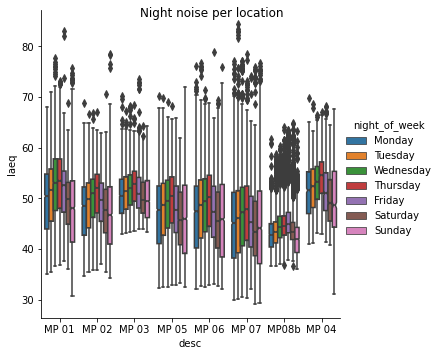

In [12]:
g1 = sns.catplot(kind='box', data = mydata, x='desc', y='laeq', hue='night_of_week', notch=True, hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
g1.fig.suptitle('Night noise per location')
plt.show()

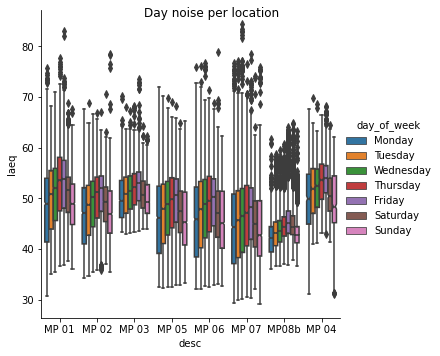

In [13]:
g2 = sns.catplot(kind='box', data = mydata, x='desc', y='laeq', hue='day_of_week', notch=True, hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
g2.fig.suptitle('Day noise per location')
plt.show()

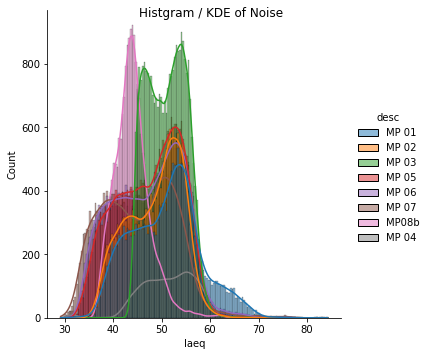

In [14]:
g3 = sns.displot(data = mydata, x='laeq', hue='desc',kde=True)
g3.fig.suptitle('Histgram / KDE of Noise')
plt.show()

From these plots, we understand that location is an important differentiator for the noise level. Therefore, we will inlude location as a Fixed Effect in our model, as we are interested in estimating the difference between the locations.

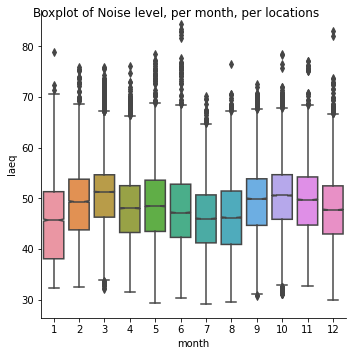

In [15]:
g4 = sns.catplot(kind='box', data = mydata, y='laeq', x='month',notch=True)
g4.fig.suptitle('Boxplot of Noise level, per month, per locations')
plt.show()

We see that month is an important differentiator for noise level. We want to control for it, therefore we will include it as a random effect in our model.

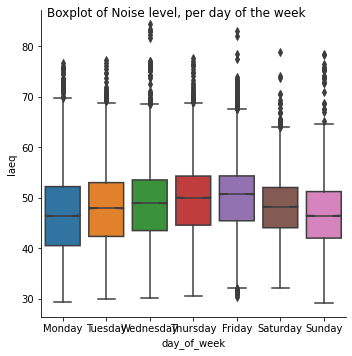

In [16]:
order = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
g5 = sns.catplot(kind='box', data = mydata, y='laeq', x='day_of_week', order=order, notch=True)
g5.fig.suptitle('Boxplot of Noise level, per day of the week')
plt.show()

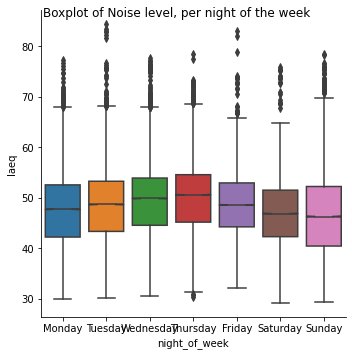

In [17]:
g6 = sns.catplot(kind='box', data = mydata, y='laeq', x='night_of_week',order=order, notch=True)
g6.fig.suptitle('Boxplot of Noise level, per night of the week')
plt.show()

Based on these, we will include in the model:

lc_dailyrain; mean_temp as Random Effects


In [18]:
# construct the mixed model, with desc 
md = smf.mixedlm("laeq ~ C(night_of_week) + C(month) + count", data = mydata, groups="desc", re_formula='~mean_temp + lc_dailyrain')
mdf = md.fit()
print(mdf.summary())

                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       laeq        
No. Observations:       177733        Method:                   REML        
No. Groups:             8             Scale:                    29.3261     
Min. group size:        5954          Log-Likelihood:           -552545.7324
Max. group size:        28439         Converged:                Yes         
Mean group size:        22216.6                                             
----------------------------------------------------------------------------
                                Coef.   Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                        45.841    3.303  13.878 0.000 39.367 52.315
C(night_of_week)[T.Monday]       -0.895    0.048 -18.576 0.000 -0.989 -0.800
C(night_of_week)[T.Saturday]     -0.755    0.049 -15.545 0.000 -0.850 -0.660
C(night_of_week)[T.

Now we will check the performance of the mixed model

In [19]:
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["noise"] = mydata.laeq
performance["predicted"] = mdf.fittedvalues

In [33]:
performance.head()
performance.describe()

,residuals,noise,predicted
count,1.777330e+05,177600.000000,177600.000000
mean,-1.792549e-12,48.036558,48.036962
std,5.414766e+00,6.550091,3.683104
min,-2.088387e+01,29.197667,35.977441
25%,-3.629317e+00,43.228064,45.507677
50%,-4.656745e-02,48.376667,47.962346
75%,3.512605e+00,53.063167,50.478631
max,4.094459e+01,84.310000,64.134059


STOP HERE TO CHECK

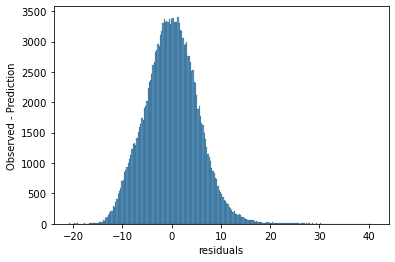

In [25]:
ax = sns.histplot(x = "residuals", data = performance)
ax.set(ylabel='Observed - Prediction')
plt.show()

Calculate RMSE of the model

In [39]:
performance.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177733 entries, 0 to 177732
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   residuals  177733 non-null  float64
 1   noise      177600 non-null  float64
 2   predicted  177600 non-null  float64
dtypes: float64(3)
memory usage: 4.1 MB


In [43]:
RMSE = np.sqrt(((performance.noise-performance.predicted)**2).mean())
RMSE

5.416375388209948